In [51]:
import torch 
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from train import train
from torch.optim import Adam
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Ammount of objects already turned to categorical format, so:
0 -  means no objects 
1 - means 1-5 objects (few)
2 - means 6-10 (some)
3 - means >10 objects (a lot)

Ammount of avalailable weapons means:
0 - no amunition of this type (0)
1 - a few amunition of this type (<10)
2 - some amunition of this type (10-50)
3 - enought amunition of this type (<50)

All of above ammounts could be changed so for example 1 as a detectes combat vehicle could mean not 1-5 but 1-3 detected objects. It will be realized in following code part.


Descisions are also turned into categorical format:
0 - means to use cluster shells 
1 - means to use unitar shells 
2 - means to use FPV kamikaze-drones
3 - means to wait for realoadings


In [53]:
data = pd.read_csv("/Users/maxkucher/shelling /artillery.csv", index_col=False)
data = data.drop("Unnamed: 0", axis='columns')
data

,tart_ammount,spart_ammount,cl_shells_ammount,u_shells_ammount,fpv_shells_ammount,descision
0,0,1,0,0,0,3
1,0,1,0,0,1,2
2,0,1,0,0,2,2
3,0,1,0,0,3,2
4,0,1,0,1,0,1
...,...,...,...,...,...,...
955,3,3,3,2,3,1
956,3,3,3,3,0,1
957,3,3,3,3,1,1
958,3,3,3,3,2,1


In [54]:
x = data.drop("descision", axis="columns")
y = data["descision"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [55]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x.values)
        self.y = torch.LongTensor(y.values)
        # self.y = self.y.reshape(-1, 1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [56]:
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

In [57]:
len(train_dataset), len(test_dataset)

(768, 192)

In [58]:
x_train.shape

(768, 5)

In [59]:
y_train.value_counts()

descision
1    576
0    144
2     36
3     12
Name: count, dtype: int64

In [60]:
train_dataset[3]

(tensor([3., 0., 0., 2., 2.]), tensor(1))

In [61]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))


In [62]:
class ArtilleryModel(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.linear1 = nn.Linear(in_features=5, out_features=28)
        self.bnorm1 = nn.BatchNorm1d(28)
        self.linear2 = nn.Linear(in_features=28, out_features=14)
        self.drop1 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(in_features=14, out_features=7)
        self.linear4 = nn.Linear(in_features=7, out_features=5)
        self.linear5 = nn.Linear(in_features=5, out_features=num_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.bnorm1(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.drop1(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        
        return out
    
    def predict(self, x):
        x = torch.FloatTensor(x).to(device)
        with torch.no_grad():
            y_pred = F.softmax(self.forward(x), dim=-1)

        return y_pred
    
model = ArtilleryModel().to(device)
model

ArtilleryModel(
  (linear1): Linear(in_features=5, out_features=28, bias=True)
  (bnorm1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=28, out_features=14, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=14, out_features=7, bias=True)
  (linear4): Linear(in_features=7, out_features=5, bias=True)
  (linear5): Linear(in_features=5, out_features=4, bias=True)
)

In [63]:
%pip install -q torchsummary

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [64]:
from torchsummary import summary

summary(model, input_size=(5, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 28]             168
       BatchNorm1d-2                   [-1, 28]              56
            Linear-3                   [-1, 14]             406
           Dropout-4                   [-1, 14]               0
            Linear-5                    [-1, 7]             105
            Linear-6                    [-1, 5]              40
            Linear-7                    [-1, 4]              24
Total params: 799
Trainable params: 799
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [65]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-2)

In [66]:
history = train(model, optimizer, loss_func, train_dataloader, test_dataloader, epochs=50, metrics=[accuracy_score], 
                device=device, task="multiclass")

Epoch    1    0sec	loss:      0.862	val_loss:      0.569	accuracy_score:       0.75	val_accuracy_score:       0.75	
Epoch    2    0sec	loss:      0.461	val_loss:      0.371	accuracy_score:       0.75	val_accuracy_score:       0.75	
Epoch    3    0sec	loss:      0.293	val_loss:      0.175	accuracy_score:      0.815	val_accuracy_score:      0.984	
Epoch    4    0sec	loss:      0.131	val_loss:     0.0607	accuracy_score:      0.966	val_accuracy_score:      0.984	
Epoch    5    0sec	loss:     0.0949	val_loss:     0.0564	accuracy_score:      0.971	val_accuracy_score:      0.984	
Epoch    6    0sec	loss:     0.0723	val_loss:     0.0453	accuracy_score:      0.971	val_accuracy_score:      0.984	
Epoch    7    0sec	loss:     0.0521	val_loss:     0.0388	accuracy_score:      0.982	val_accuracy_score:      0.984	
Epoch    8    0sec	loss:     0.0481	val_loss:     0.0327	accuracy_score:      0.979	val_accuracy_score:      0.984	
Epoch    9    0sec	loss:     0.0464	val_loss:     0.0359	accuracy_score:

In [67]:
loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

predicted_classes = torch.argmax(y_pred, dim=1).cpu().numpy()

print(predicted_classes)


[1 1 0 1 1 1 1 2 1 1 1 0 1 1 1 1 2 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 3 1 1
 0 1 1 1 2 1 1 1 1 3 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 2 0 1 0 0 1 1 0 1 1 3 1 1 1 2 1 1 0 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 2 0 1 1 1 1
 1 2 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 2 1 1 1 1
 1 1 1 1 1 1 1]


In [68]:
len(y_test)

192

[]

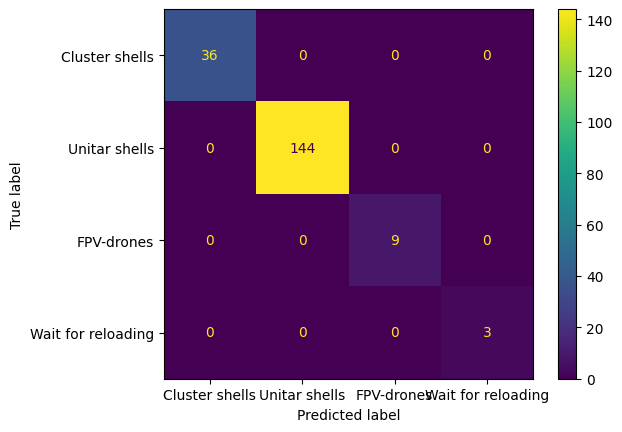

In [79]:
commands = ["Cluster shells", "Unitar shells", "FPV-drones", "Wait for reloading"]

ConfusionMatrixDisplay.from_predictions(y_test, predicted_classes, display_labels=commands)
plt.plot()

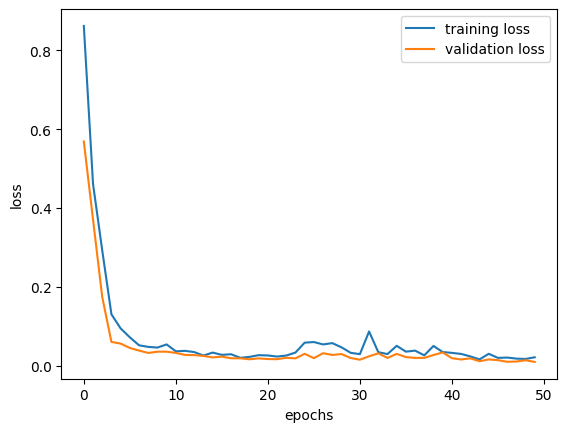

In [70]:
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [71]:
data[data["descision"] == 3] 

,tart_ammount,spart_ammount,cl_shells_ammount,u_shells_ammount,fpv_shells_ammount,descision
0,0,1,0,0,0,3
64,0,2,0,0,0,3
128,0,3,0,0,0,3
192,1,0,0,0,0,3
256,1,1,0,0,0,3
320,1,2,0,0,0,3
384,1,3,0,0,0,3
448,2,0,0,0,0,3
512,2,1,0,0,0,3
576,2,2,0,0,0,3


In [72]:
import torch

commands = ["Cluster shells", "Unitar shells", "FPV-drones", "Wait for reloading"]

x = torch.FloatTensor([0, 2, 0, 0, 0]).to(device)
x = x.unsqueeze(0)
model.eval()

with torch.no_grad():
    res = model(x)

t_x = torch.argmax(res)
t_array = np.array(t_x)


print(commands[t_array])


Wait for reloading


In [76]:
torch.save(model, "artillery.pt")

In [77]:
m = torch.load("/Users/maxkucher/shelling /artillery.pt")

In [78]:
summary(m, input_size=(5,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 28]             168
       BatchNorm1d-2                   [-1, 28]              56
            Linear-3                   [-1, 14]             406
           Dropout-4                   [-1, 14]               0
            Linear-5                    [-1, 7]             105
            Linear-6                    [-1, 5]              40
            Linear-7                    [-1, 4]              24
Total params: 799
Trainable params: 799
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
torch.save(model.state_dict(), "artillery.pt")